In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
tf.config.set_visible_devices([], 'GPU')

In [2]:
data=yf.download('0017.hk','2018-01-01','2022-04-09')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-30,32.450001,33.150002,32.150002,32.750000,32.750000,4210692,32.291667,31.270833,69.993115,-27.586298,-9.195433,1.549999,2.700001,31.671357,31.360402,0.310956,1.100002,43.594085,27.232603,31.850000
2022-03-31,32.750000,33.250000,31.850000,31.850000,31.850000,4453060,32.266667,31.500000,53.084221,-96.551647,-49.122787,-0.150000,2.750000,31.698841,31.396668,0.302173,1.400000,3.689542,7.894827,32.150002
2022-04-01,31.850000,32.200001,31.500000,32.150002,32.150002,2053614,32.266667,31.816667,57.113335,-62.857056,-42.307627,0.000000,3.800001,31.768250,31.452471,0.315780,0.700001,13.324383,12.718728,32.400002
2022-04-04,32.150002,32.400002,31.700001,32.400002,32.400002,1631328,32.258334,31.979167,60.418174,-48.571341,-36.170142,-0.049999,1.950001,31.865443,31.522658,0.342785,0.700001,21.206780,16.685529,32.299999
2022-04-06,32.450001,32.450001,31.900000,32.299999,32.299999,3053935,32.250000,32.054167,58.320835,-54.285758,-44.186090,-0.049999,0.900000,31.932298,31.580239,0.352059,0.550001,16.137067,14.416364,31.850000


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_20865/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


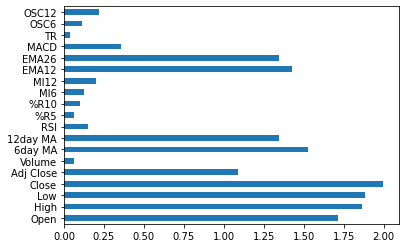

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(734, 1, 11) (734, 1) (184, 1, 11) (184, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_20865/3942108283.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
#     kernel_regularizer=regularizers.l1(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-11 05:22:40.350012: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42/42 [==============================] - 2s 15ms/step - loss: 1823.2046 - val_loss: 1283.3293
Epoch 2/500
42/42 [==============================] - 0s 3ms/step - loss: 1190.4077 - val_loss: 195.4480
Epoch 3/500
42/42 [==============================] - 0s 2ms/step - loss: 65.6718 - val_loss: 21.6472
Epoch 4/500
42/42 [==============================] - 0s 2ms/step - loss: 45.6595 - val_loss: 20.9878
Epoch 5/500
42/42 [==============================] - 0s 2ms/step - loss: 34.4664 - val_loss: 22.1319
Epoch 6/500
42/42 [==============================] - 0s 2ms/step - loss: 27.6762 - val_loss: 17.3400
Epoch 7/500
42/42 [==============================] - 0s 2ms/step - loss: 23.1075 - val_loss: 15.1552
Epoch 8/500
42/42 [==============================] - 0s 2ms/step - loss: 19.2487 - val_loss: 12.5586
Epoch 9/500
42/42 [==============================] - 0s 2ms/step - loss: 16.1465 - val_loss: 10.4734
Epoch 10/500
42/42 [==============================] - 0s 2ms/step - loss: 13.5277 - val_loss: 8

Epoch 83/500
42/42 [==============================] - 0s 2ms/step - loss: 1.3661 - val_loss: 0.8441
Epoch 84/500
42/42 [==============================] - 0s 2ms/step - loss: 1.4308 - val_loss: 0.8447
Epoch 85/500
42/42 [==============================] - 0s 2ms/step - loss: 1.5043 - val_loss: 0.8302
Epoch 86/500
42/42 [==============================] - 0s 2ms/step - loss: 1.5885 - val_loss: 0.7993
Epoch 87/500
42/42 [==============================] - 0s 2ms/step - loss: 1.6864 - val_loss: 0.7525
Epoch 88/500
42/42 [==============================] - 0s 2ms/step - loss: 1.8018 - val_loss: 0.6942
Epoch 89/500
42/42 [==============================] - 0s 2ms/step - loss: 1.9410 - val_loss: 0.6362
Epoch 90/500
42/42 [==============================] - 0s 2ms/step - loss: 2.1141 - val_loss: 0.6037
Epoch 91/500
42/42 [==============================] - 0s 2ms/step - loss: 2.3378 - val_loss: 0.6459
Epoch 92/500
42/42 [==============================] - 0s 2ms/step - loss: 2.6395 - val_loss: 0.8542


42/42 [==============================] - 0s 2ms/step - loss: 0.7172 - val_loss: 0.4216
Epoch 246/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7512 - val_loss: 0.4016
Epoch 247/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7713 - val_loss: 0.3956
Epoch 248/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7780 - val_loss: 0.3952
Epoch 249/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7753 - val_loss: 0.3966
Epoch 250/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7679 - val_loss: 0.3979
Epoch 251/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7600 - val_loss: 0.3986
Epoch 252/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7542 - val_loss: 0.3987
Epoch 253/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7510 - val_loss: 0.3984
Epoch 254/500
42/42 [==============================] - 0s 2ms/step - loss: 0.7496 - val_loss: 0.3979
Epoc

42/42 [==============================] - 0s 2ms/step - loss: 0.6145 - val_loss: 0.4329
Epoch 408/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6220 - val_loss: 0.4347
Epoch 409/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6236 - val_loss: 0.4428
Epoch 410/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6191 - val_loss: 0.4419
Epoch 411/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6276 - val_loss: 0.4327
Epoch 412/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6502 - val_loss: 0.4350
Epoch 413/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6532 - val_loss: 0.4524
Epoch 414/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6381 - val_loss: 0.4567
Epoch 415/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6486 - val_loss: 0.4362
Epoch 416/500
42/42 [==============================] - 0s 2ms/step - loss: 0.6978 - val_loss: 0.4305
Epoc

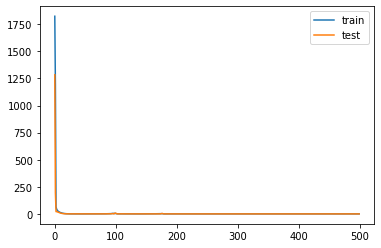

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

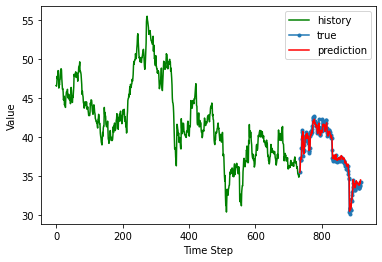

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

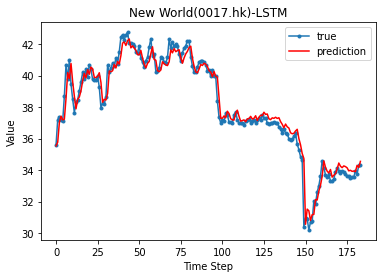

In [21]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('New World(0017.hk)-LSTM')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.9568244015052316

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.012091713527779603

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

0.6483097299598408

In [16]:
x_val=data_val.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_20865/3570560286.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1)


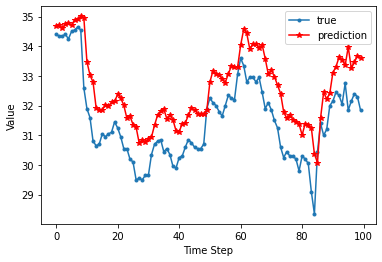

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.25709512888881747

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.035123140696040084

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

1.1896528024440531